<a href="https://colab.research.google.com/github/DenuraTHEbest/InvestHere/blob/Amna_S/ASPI_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input feature columns: ['Open', 'High', 'Low', 'Vol.', 'Change %', 'Price_Lag1', 'Vol_Lag1', 'Price_MA_5', 'Price_MA_10', 'Price_MA_20', 'Price_Volatility_5', 'Price_Volatility_20', 'Lagged_Sentiment_1', 'Lagged_Sentiment_2', 'Lagged_Sentiment_3', 'Lagged_Sentiment_4', 'Lagged_Sentiment_5', 'Price_Lag10', 'Vol_Lag10', 'Price_Lag20', 'Vol_Lag20', 'Price_Lag30', 'Vol_Lag30']
Cross-Validation RMSE Scores: [2469.55924889  444.81314442  270.17856453  332.73230605  277.92591301]
Final RMSE: 277.9259
Standard Deviation of RMSE: 857.5324
Cross-Validation R² Scores: [-2.56403387  0.73062287  0.63079586  0.87866666  0.84525004]
Final R²: 0.8453
Standard Deviation of R²: 1.3370


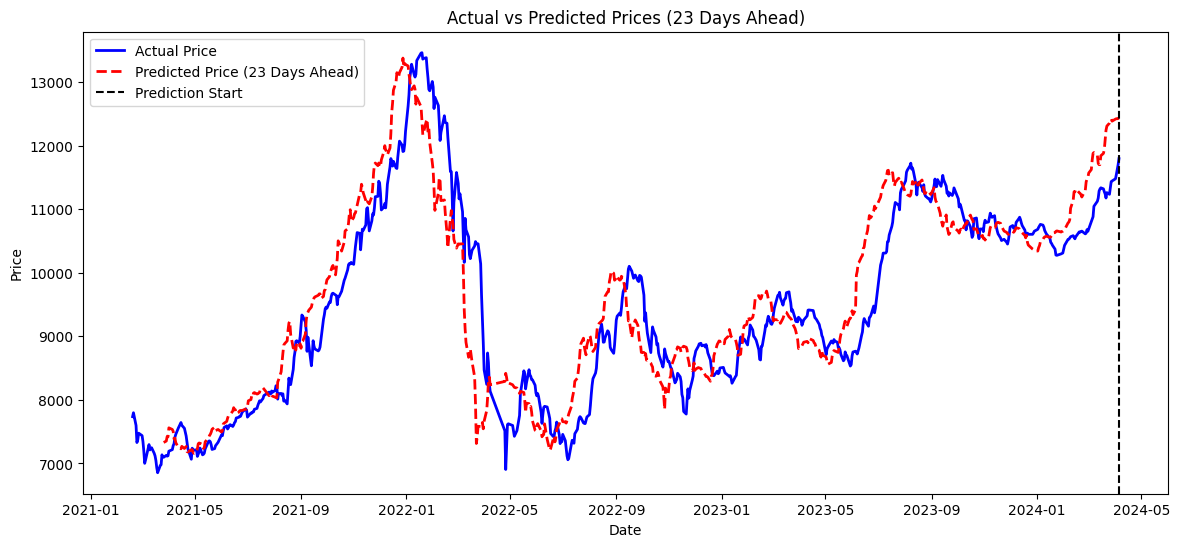

In [11]:
import pandas as pd
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import cross_validate, TimeSeriesSplit
!pip install -U scikit-learn
# Mount Google Drive
drive.mount('/content/drive')

# Load datasets
aspi_data = pd.read_csv('/content/drive/My Drive/CSE_All_Share_Historical_Data_Processed.csv')
sentiment_data = pd.read_csv('/content/drive/My Drive/daily_weighted_scores_9-12.csv')

# Convert the Date columns to pandas datetime for both datasets
aspi_data['Date'] = pd.to_datetime(aspi_data['Date'])  # Already in YYYY-MM-DD format
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])  # Already in YYYY-MM-DD format

# Filter for the common date range
common_start_date = max(aspi_data['Date'].min(), sentiment_data['Date'].min())
common_end_date = min(aspi_data['Date'].max(), sentiment_data['Date'].max())

aspi_data = aspi_data[(aspi_data['Date'] >= common_start_date) & (aspi_data['Date'] <= common_end_date)]
sentiment_data = sentiment_data[(sentiment_data['Date'] >= common_start_date) & (sentiment_data['Date'] <= common_end_date)]

# Sort both datasets by date in ascending order
aspi_data = aspi_data.sort_values(by='Date')
sentiment_data = sentiment_data.sort_values(by='Date')

# Merge datasets with lagged sentiment features
# Use a lag of 1 to 5 days for the sentiment scores
for lag in range(1, 6):  # 5 days lag
    sentiment_data[f'Lagged_Sentiment_{lag}'] = sentiment_data['Weighted_Sentiment'].shift(lag)

# Drop rows with NaN values introduced by shifting
sentiment_data = sentiment_data.dropna(subset=[f'Lagged_Sentiment_{lag}' for lag in range(1, 6)])

# Merge the sentiment data with the ASPI data
merged_data = pd.merge(aspi_data, sentiment_data[['Date'] + [f'Lagged_Sentiment_{lag}' for lag in range(1, 6)]],
                       on='Date', how='left')

merged_data['Price_Lag10'] = merged_data['Price'].shift(10)
merged_data['Vol_Lag10'] = merged_data['Vol.'].shift(10)
merged_data['Price_Lag20'] = merged_data['Price'].shift(20)
merged_data['Vol_Lag20'] = merged_data['Vol.'].shift(20)
merged_data['Price_Lag30'] = merged_data['Price'].shift(30)
merged_data['Vol_Lag30'] = merged_data['Vol.'].shift(30)

# Set the target variable 'y' as the 'Price' column, shifted by -1 to predict the next 7 days' prices
for i in range(1, 24):  # Predict for the next 23 days
    merged_data[f'Target_{i}'] = merged_data['Price'].shift(-i)

merged_data = merged_data.dropna()  # Remove the last rows with NaN in target columns

# Features (X) include all lagged sentiment features and other relevant columns
X = merged_data.drop(columns=['Date', 'Price'] + [f'Target_{i}' for i in range(1, 24)]) #removed 8 and replaced it with 24

# Print the column names being used as inputs
print("Input feature columns:", X.columns.tolist())

y = merged_data[[f'Target_{i}' for i in range(1, 24)]]  # Multi-output target for 23 days

cv = TimeSeriesSplit(n_splits=5)  # Proper way to do time series validation

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation with multiple metrics
cv_results = cross_validate(
    model, X, y, cv=cv,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=False
)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
r2_scores = cv_results['test_r2']

# Print metrics
print("Cross-Validation RMSE Scores:", rmse_scores)
#print(f"Mean RMSE: {rmse_scores.mean():.4f}")
final_rmse = rmse_scores[-1]  # Last RMSE value
print(f"Final RMSE: {final_rmse:.4f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.4f}")
print("Cross-Validation R² Scores:", r2_scores)
#print(f"Mean R²: {r2_scores.mean():.4f}")
final_r2 = r2_scores[-1]  # Last R² value
print(f"Final R²: {final_r2:.4f}")
print(f"Standard Deviation of R²: {r2_scores.std():.4f}")

# Train the model on the full dataset for visualization purposes
model.fit(X, y)

# Predict the next week's prices (7 days ahead) for the entire dataset
forecasted_prices = model.predict(X)

# Create a new DataFrame for visualizing the forecasted prices
forecasted_df = pd.DataFrame(forecasted_prices, columns=[f'Predicted_Target_{i}' for i in range(1, 24)])

for i in range(1, 24):
     merged_data[f'Predicted_Target_{i}'] = forecasted_df[f'Predicted_Target_{i}'].shift(i)

# # Create subplots for each predicted day (1 to 7)
# fig, axes = plt.subplots(23, 1, figsize=(14, 28), sharex=True)

# # Loop through each predicted day and create a separate graph
# for i in range(1, 24):
#     ax = axes[i-1]
#     ax.plot(merged_data['Date'], merged_data['Price'], label='Actual Price', color='blue', linewidth=1)
#     ax.plot(merged_data['Date'], merged_data[f'Predicted_Target_{i}'], label=f'Predicted Price {i} Day(s) Ahead', linestyle='--', linewidth=2)
#     ax.set_title(f'Predicted Price {i} Day(s) Ahead')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Price')
#     ax.legend(loc='upper left')
#     ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the ticks as Year-Month
#     ax.tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better readability

# plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
#plt.show()

#=======
plt.figure(figsize=(14, 6))

# Define the cutoff point where predictions start
cutoff_date = merged_data['Date'].iloc[-23]  # The last date that has actual values before predictions start

# Plot actual prices only up to the cutoff date
plt.plot(merged_data['Date'][merged_data['Date'] <= cutoff_date],
         merged_data['Price'][merged_data['Date'] <= cutoff_date],
         label='Actual Price', color='blue', linewidth=2)

# Create the missing column by shifting the Predicted_Target_23 column
merged_data['Predicted_Target_23_Shifted'] = merged_data['Predicted_Target_23'].shift(23)

# Plot predicted prices from the cutoff date onward
plt.plot(merged_data['Date'],
         merged_data['Predicted_Target_23_Shifted'],
         linestyle='--', color='red', linewidth=2, label='Predicted Price (23 Days Ahead)')

plt.axvline(x=cutoff_date, color='black', linestyle='dashed', label='Prediction Start')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (23 Days Ahead)')
plt.legend()
plt.show()